# Python optimization
## Jakub Urban

* I am a Python software / data engineer / scientist at Quantlane.
* We are a trading company using our own trading platform with > 90 % Python code base.
* My (rather long) roots are in numerical simulations in the thermonuclear fusion research.

In [1]:
%matplotlib inline

import seaborn
import matplotlib.pyplot as plt

seaborn.set_style("whitegrid")
seaborn.set_context("talk")

In [2]:
import numpy as np
import pandas
import numba

In [3]:
import dask.distributed
import dask.array

# Python is sloooow


* Is it? 

* It depends ... But we can optimize :-)

* ... when appropriate

# When / what to optimize

> Premature optimization is the root of all evil.

* Typically, we are optimizing total costs (human work + computer time + HW) vs profit.
* Remember: Development is rapid (~ cheap) in Python, with some sacrifices in performace.

Typical optimization goals:
* Faster execution.
* Less memory consumption.
* Better scaling with problem size and / or available CPU / memory.

Remember, the Pareto (80/20) principle holds: 80% of the effects (~CPU time) come from 20% of the causes (= source code).

## Xkcd is never wrong :)

![XKCD Optimization](https://imgs.xkcd.com/comics/optimization.png "Optimization")


# Profiling is your first step

... after implementing a working piece of code.

Use tools like these for profiling memory and CPU:
* [`cprofile`](https://docs.python.org/3/library/profile.html#module-cProfile) + `%prun` magic
* [line_profiler](https://github.com/rkern/line_profiler) + `%lprun`
* [memory_profiler](https://pypi.org/project/memory-profiler/) + `%mprun`
* [Snakeviz](https://jiffyclub.github.io/snakeviz/)
* [ipython_memory_usage](https://github.com/ianozsvald/ipython_memory_usage)
* [Py-spy](https://github.com/benfred/py-spy)
* [psrecord](https://github.com/astrofrog/psrecord)
* [Pympler](https://pythonhosted.org/Pympler/)


# Optimizing numerical calculations

* Here I address optimizations of *numerical calculations*, which typically involves `numpy` arrays or `Pandas` dataframes.
* Other kinds of optimization may require different approaches and tools.

# A simple, though realistic example 

We have found out (using profiling tools etc.) that 
1. The bottle neck of our project is the calculation of the (Euclidean) distance of an array of point.
2. It is worth our time to optimize it because is will save a lot of resources.

`def euclidean_distance(x, y):` $\sqrt {\sum_{i=1}^N {{{\left( {{x_i} - {y_i}} \right)}^2}} } $, where ${\bf x}$, ${\bf y}$ are $N$-dimensional vectors.

We need to calculate the distance for $M$ points, stored in an $M$ by $N$ array ${\bf X}$.

(Based on [Jake VdP's numba-vs-cython-take-2](http://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2))


# Input random data

In [4]:
M = 1000
N = 3
X = np.random.random((M, N))

# Reference implementation == `numpy`

* `numpy` is the default no. 1 choice for a calculation like this.
* Broadcasting is handy for the reduction (the inner loop).

In [5]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, np.newaxis, :] - X) ** 2).sum(-1))

# `%timeit` the performace

In [6]:
pairwise_times = {}

pairwise_times['numpy'] = %timeit -o pairwise_numpy(X)

21.9 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# #2: Python loops

* `for i in range(...): work_with(x[i])` is a typical *don't*.
* Let's see why (whether) it is so.


In [7]:
def pairwise_loops(X):
    M, N = X.shape
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

In [8]:
pairwise_times['loops'] = %timeit -o pairwise_loops(X)

2.57 s ± 89.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
def plot_timings(pairwise_times, filter_out={}):
    timings = pandas.DataFrame.from_dict(pairwise_times, orient='index', columns=['timing'])
    
    sel = np.logical_not(timings.index.isin(filter_out))
    timings = timings[sel]
    
    timings['average'] = timings['timing'].map(lambda t: t.average)
    
    fig, ax = plt.subplots(figsize=(8, 4))

    ax = timings.sort_values('average').plot.bar(y='average', ax=ax, legend=False)

    ax.set_ylabel('time [ms]')
    ax.set_yscale('log')
    plt.xticks(rotation=45)

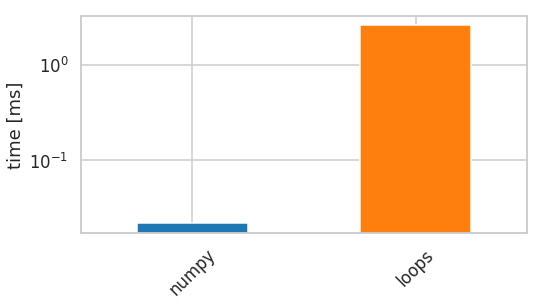

In [10]:
plot_timings(pairwise_times)

# Test the function

Careful with comparing floating point (finite precision) numbers. This:
```python
assert np.all(pairwise_numpy(X) == pairwise_loops(X))
```
may yield a false negative result.

`np.allclose` suits better:

In [11]:
def assert_we_are_happy(result):
    assert np.allclose(result, pairwise_numpy(X), rtol=1e-10, atol=1e-15)
    print('Yes')

In [12]:
assert_we_are_happy(pairwise_loops(X))

Yes


# #3 Down to the C(ython) level

* [Cython](https://cython.org/) is a mature tool, which could be a single topic for the whole meetup.
* It *extends* the Python language mainly by `cimport`s and C/C++ types.
* Cython translates your `.pyx` file to C or C++ and compiles it into a Python module.
* Batteries included: static typing, interfacing with C/C++ (both directions), typed memoryviews and buffer protocol, ...


Let us start with just *Cythonizing* the loops version (no effect on the `Numpy` version).

In [13]:
%load_ext Cython

In [14]:
%%cython -a

import numpy as np
cimport numpy as np
from libc.math cimport sqrt

def pairwise_cython_0(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

1. Optimize via types (`cdef`)

In [15]:
%%cython -a

import numpy as np
cimport numpy as np
from libc.math cimport sqrt

def pairwise_cython_1(np.ndarray[np.float64_t, ndim=2] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef np.ndarray D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return D

### Don't trust any one / anything and test

In [16]:
assert_we_are_happy(pairwise_cython_0(X))
assert_we_are_happy(pairwise_cython_1(X))

Yes
Yes


And the performance?

In [17]:
pairwise_times['cython0'] = %timeit -o pairwise_cython_0(X)

3.08 s ± 47.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
pairwise_times['cython1'] = %timeit -o pairwise_cython_1(X)

95.7 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


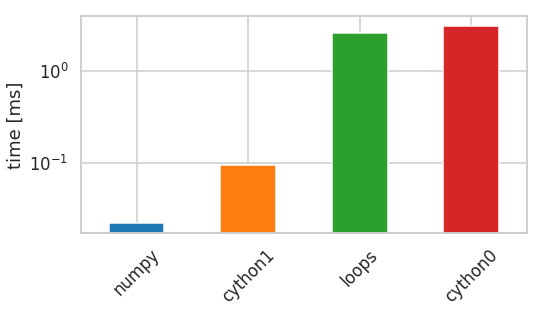

In [19]:
plot_timings(pairwise_times)

## More optimization using

* `@boundscheck(False)`: Do no check array bounds.
* `@wraparound(False)`: Disable negative indexing.

In [20]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython_2(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [21]:
assert_we_are_happy(pairwise_cython_2(X))

Yes


In [22]:
pairwise_times['cython2'] = %timeit -o pairwise_cython_2(X)

5.29 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


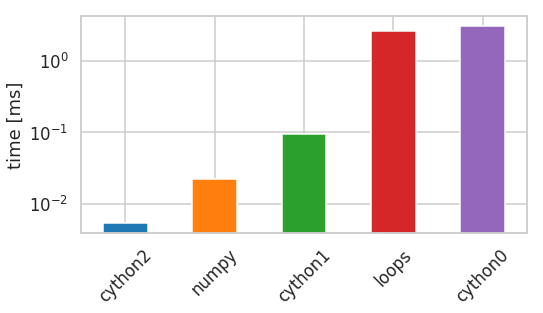

In [23]:
plot_timings(pairwise_times)

# The Olde Good Fortran 

* Fortran is ancient, though still actively used (for better and worse reasons).
* Modern Fortran compilers are quite powerful.
* Numpy comes with [`f2py`](https://docs.scipy.org/doc/numpy/f2py/) that easily binds a Fortran/C code for Python.

Let's code some `FORTRAN` :)

In [24]:
%%file pairwise_fortran.f90

subroutine pairwise_fortran(X, D, m, n)
    integer :: n,m
    double precision, intent(in) :: X(m, n)
    double precision, intent(out) :: D(m, m) 
    integer :: i, j, k
    double precision :: r, tmp
    
    do j = 1, m 
        do i = 1, m 
            r = 0
            do k = 1, n 
                tmp = (X(i, k) - X(j, k))
                r = r + tmp * tmp
            end do 
            D(i, j) = sqrt(r) 
        end do 
    end do 
end subroutine

Writing pairwise_fortran.f90


`f2py` the file (and yes, a [`%%fortran` magic](https://pypi.org/project/fortran-magic/) does exist).

In [25]:
!f2py -c --f90flags=-O -DF2PY_REPORT_ON_ARRAY_COPY pairwise_fortran.f90 -m pairwise_fortran | tail -5

In file included from /home/development/.pyenv/versions/3.7.2/envs/pydata-talk-3.7.2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /home/development/.pyenv/versions/3.7.2/envs/pydata-talk-3.7.2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/development/.pyenv/versions/3.7.2/envs/pydata-talk-3.7.2/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpvvmxc69_/src.linux-x86_64-3.7/fortranobject.h:13,
                 from /tmp/tmpvvmxc69_/src.linux-x86_64-3.7/pairwise_fortranmodule.c:16:
/home/development/.pyenv/versions/3.7.2/envs/pydata-talk-3.7.2/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^
In file included from 

In [26]:
from pairwise_fortran import pairwise_fortran
print(pairwise_fortran.__doc__)

d = pairwise_fortran(x,[m,n])

Wrapper for ``pairwise_fortran``.

Parameters
----------
x : input rank-2 array('d') with bounds (m,n)

Other Parameters
----------------
m : input int, optional
    Default: shape(x,0)
n : input int, optional
    Default: shape(x,1)

Returns
-------
d : rank-2 array('d') with bounds (m,m)



As usual - test and time it ...

Use `numpy.asfortranarray` to prevent data copy.

In [27]:
XF = np.asfortranarray(X)

In [28]:
assert_we_are_happy(pairwise_fortran(XF))

Yes


In [29]:
pairwise_times['fortran'] = %timeit -o pairwise_fortran(XF)

3.07 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Grand finale with `numba`

> [Numba](http://numba.pydata.org/) is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code. 

* Leverages LLVM.
* Built for data and science.
* Straightforward to use.


`jit` is a just-in-time compilation decorator:
```
@numba.jit(
    signature=None, 
    nopython=False, 
    nogil=False, 
    cache=False, 
    forceobj=False, 
    parallel=False, 
    error_model='python', 
    fastmath=False, locals={}
)
```

In [30]:
import numba

pairwise_numba = numba.jit(pairwise_loops)

Have you noticed? We are compiling the slow loop version (just like with Cython).

In [31]:
assert_we_are_happy(pairwise_numba(X))

Yes


In [32]:
pairwise_times['numba'] = %timeit -o pairwise_numba(X)

2.63 ms ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
@numba.jit(nopython=True, fastmath=True)
def _pairwise_nopython(X: np.ndarray, D: np.ndarray) -> np.ndarray:
    M = X.shape[0]
    N = X.shape[1]
    for i in numba.prange(M):
        for j in numba.prange(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = numpy.sqrt(d)
    return D


def pairwise_numba_fast(X: np.ndarray) -> np.ndarray:
    D = np.empty((X.shape[0], X.shape[0]), dtype = numpy.float)
    _pairwise_nopython(X, D)
    return D

In [34]:
# assert_we_are_happy(pairwise_numba_fast(X))

In [35]:
# pairwise_times['numba_fast'] = %timeit -o pairwise_numba_fast(X)

# Compare all the results

Numba and Cython are the two winners here, beating Fortran (a little bit) and Numpy (significantly).

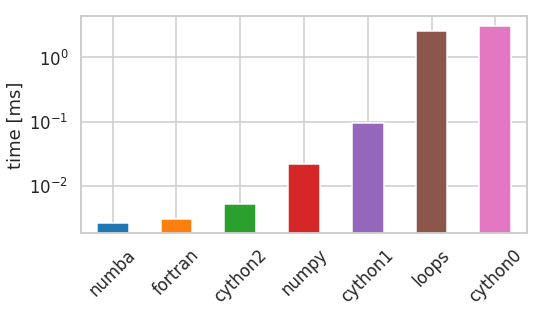

In [36]:
plot_timings(pairwise_times)

# Memory usage is also important

* In particular the scaling with the problem size.

In [37]:
import ipython_memory_usage.ipython_memory_usage as imu

In [38]:
imu.start_watching_memory()

In [38] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 237.32 MiB


In [39]:
D = pairwise_numpy(X)

In [39] used 0.0000 MiB RAM in 0.17s, peaked 0.00 MiB above current, total RAM usage 237.32 MiB


Let's try and Xtra-Large input data: 
* `5 * M, 2 * N` (not that large ...)

In [40]:
XL = np.random.random((M * 5, N * 2))

In [40] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 237.32 MiB


In [41]:
DXL = pairwise_numpy(XL)

In [41] used 190.6016 MiB RAM in 1.42s, peaked 1144.29 MiB above current, total RAM usage 427.93 MiB


The `peaked` value can be surprisingly large!

The loops + Numba / Cython resolves the memory issue in this case:

In [42]:
DXL_numba = pairwise_numba(XL)

In [42] used 190.5078 MiB RAM in 0.31s, peaked 0.00 MiB above current, total RAM usage 618.43 MiB


In [43]:
del XL
del DXL
del DXL_numba

In [43] used -381.2227 MiB RAM in 0.26s, peaked 381.24 MiB above current, total RAM usage 237.21 MiB


In [44]:
imu.stop_watching_memory()

# Quick thoughts on parallelizing

> Premature parallelization is the source of all the remaining evil.

* Try to use what's available already.
* Leverage natural (embarassing) parallelism in your code / use cases.
    * Typical example: *parallel map*.
* Start parallelizing on the high level.
* Avoid threads, not only because of GIL (the unfamous global interpreter lock).

## Python's standard lib abstraction

[`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) is the place to start.
* `Executor` abstracts out running tasks concurrently via its `submit` and `map` methods.
    * `ThreadPoolExecutor`, `ProcessPoolExecutor`
    * 3rd party libs like `Dask`, `ipyparallel` or `mpi4py` expose the same API.
* `Future` encapsulates the asynchronous execution of a callable.
    * Enables non-blocking calls.
    * Can be queried for status, result, cancelled, etc.
    * `asyncio.wrap_future(Future)` can be `await`ed.
* You can create asynchronous pipelines by passing `Future`s or using callbacks.

# Parallel map example

1. Using `Executor.submit`

In [45]:
import concurrent.futures

executor = concurrent.futures.ThreadPoolExecutor(max_workers=4)

inputs = [np.random.sample((100, 3)) for _ in range(4)]

outputs = [executor.submit(pairwise_numpy, x) for x in inputs]

outputs

[<Future at 0x7fd77ff69780 state=finished returned ndarray>,
 <Future at 0x7fd77ff69908 state=finished returned ndarray>,
 <Future at 0x7fd77ff69a58 state=running>,
 <Future at 0x7fd77ff69c50 state=running>]

`wait` for the `Future` results:

In [46]:
done, not_done = concurrent.futures.wait(outputs)

print(f'{len(done)} tasks done, {len(not_done)} not done')

4 tasks done, 0 not done


In [47]:
results = [future.result() for future in done]

## `Executor.map` yields a generator

In [48]:
outputs = executor.map(pairwise_numpy, inputs)
outputs

<generator object Executor.map.<locals>.result_iterator at 0x7fd77fde7d68>

In [49]:
results = [output for output in outputs]

* Dask, ipyparallel offers scalable (cluster) executors.
* Dask has chunked collections.

# Scaling up / out `concurrent.futures`

* Various frameworks expose the `Executor` API and yield `Future`'s:
  * [Dask](http://docs.dask.org/en/latest/futures.html)
  * [`mpi4py`](https://mpi4py.readthedocs.io/en/stable/mpi4py.futures.html)
  * [IPyParallel](https://ipyparallel.readthedocs.io)

# Low-level parallelization

* Numba has `jit(parallel=True)` and `prange`.
* Cython can use OpenMP, has `prange` as well.
* `mpi4pi` is handy for large-scale codes.
* [Dask (high-level collections)](http://docs.dask.org/en/latest/user-interfaces.html#high-level-collections)

*Now that we have found out that we can make use of additinal performace boost of the already optimized `pairwise` function if run efficiently on multiple CPU cores.* 

Let's start parallelizing!

# Numba is powerful again

* Trivial changes already yield the desired effect.
  * `@numba.jit(parallel=True)` + `numba.prange`

In [50]:
@numba.jit(parallel=True)
def pairwise_numba_prange(X):
    M, N = X.shape
    D = np.empty((M, M), dtype=np.float)
    for i in numba.prange(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

In [51]:
# we actually don't need this, might be useful for an MPI implementation though

def pairwise_chunks(X, n_chunks=4):
    M, N = X.shape
    D = np.empty((M, M), dtype=np.float)
    
    for chunk in numba.prange(n_chunks):
        lo = int(chunk * M / n_chunks)
        hi = int((chunk + 1) * M / n_chunks)
        for i in range(lo, hi):
            for j in range(M):
                d = 0.0
                for k in range(N):
                    tmp = X[i, k] - X[j, k]
                    d += tmp * tmp
                D[i, j] = np.sqrt(d)
    return D

In [52]:
assert_we_are_happy(pairwise_numba_prange(X))

Yes


In [53]:
pairwise_times['numba_parallel'] = %timeit -o pairwise_numba_prange(X)

1.52 ms ± 36.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


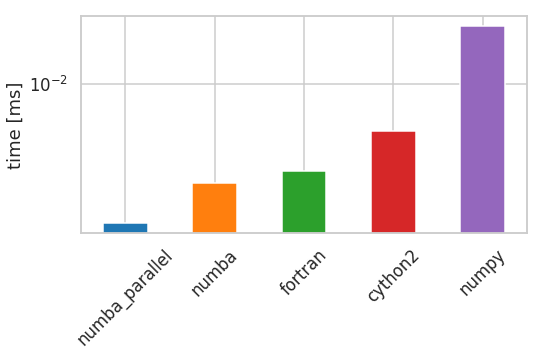

In [54]:
plot_timings(pairwise_times, filter_out=['loops', 'cython0', 'cython1'])

# Cython is a bit more elaborate

* Cython provides `cython.parallel.prange(..., nogil=True)`.
* Reductions are automatically detected (e.g. `sum += x[i, j]`).
  * Not in the case of our `pairwise` :(
* Thread-local variables are not straightforward.

In [55]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

import numpy as np
import cython.parallel

cimport numpy as np
cimport cython
from libc.math cimport sqrt
from libc.stdlib cimport malloc, free
cimport openmp

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, ::1] X):
    cdef Py_ssize_t M = X.shape[0]
    cdef Py_ssize_t N = X.shape[1]

    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)

    cdef Py_ssize_t i, j, k
    cdef double *p_sum, *p_tmp
    cdef double *d, *tmp

    cdef int n_threads = 4
    # https://groups.google.com/forum/#!topic/cython-users/Ady-DdWu6rE
    p_sum = <double *> malloc(sizeof(double) * openmp.omp_get_max_threads() * 32)
    p_tmp = <double *> malloc(sizeof(double) * openmp.omp_get_max_threads() * 32)
    
    for i in cython.parallel.prange(M, nogil=True, num_threads=n_threads):
        d = p_sum + 32 * cython.parallel.threadid()
        tmp = p_tmp + 32 * cython.parallel.threadid()
        for j in range(M):
            d[0] = 0.0
            for k in range(N):
                tmp[0] = X[i, k] - X[j, k]
                d[0] += tmp[0] * tmp[0]
            D[i, j] = sqrt(d[0])
    return np.asarray(D)

# Dask is ...

Essentially, [Dask](https://dask.org/) is:
* High-level collections: `Dataframe`, `array`, `bag`.
* Low-level (distributed) executor.

# A way too short introduction to Dask collections

*Please follow the execellent [Dask tutorial](https://github.com/dask/dask-tutorial) to learn Dask.*

# 1. Create a collection

* Either from existing objects (arrays, dataframes, ...)
* Or, better, from out-of-core storage (local files, databases, cloud).
  * Data will be read only when needed.

In [56]:
X_dask = dask.array.from_array(X, chunks=(500, -1))
X_dask

dask.array<array, shape=(1000, 3), dtype=float64, chunksize=(500, 3)>

The chunk size is absolute - it's an estimate on how large chunks can be processed.

# 2. Create a delayed (async) computation

* Wrap functions by `dask.delayed`.
* Dask collections' methods create delayed calls automatically.

In [57]:
result = dask.delayed(sum)(X)
result

Delayed('sum-3e76af44-13f5-4953-9fdb-057f33f9f04f')

In [58]:
result.compute()

array([469.48211724, 500.76532232, 505.36170997])

Delayed happens auto-magcally with Dask collections :) 

Let's create the `pairwise` Numpy implementation step by step:

In [59]:
D_1 = (X_dask[:, np.newaxis, :] - X_dask) ** 2
D_1

dask.array<pow, shape=(1000, 1000, 3), dtype=float64, chunksize=(500, 500, 3)>

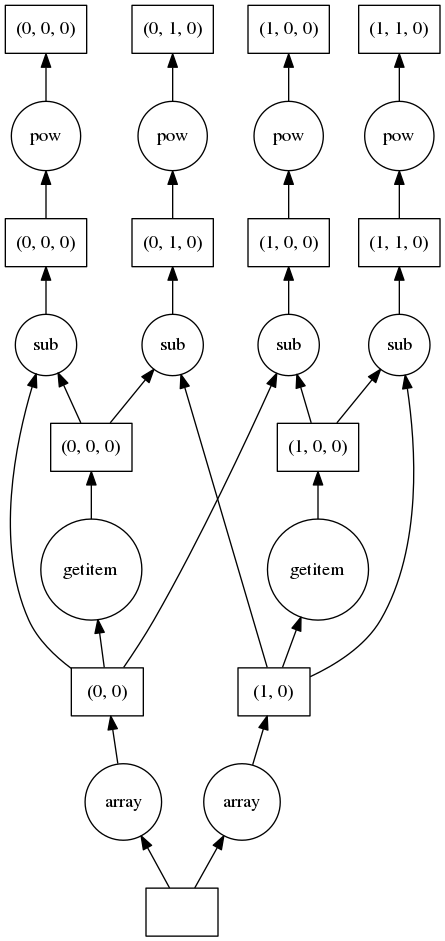

In [60]:
D_1.visualize()

In [61]:
D_2 = D_1.sum(-1)
D_2

dask.array<sum-aggregate, shape=(1000, 1000), dtype=float64, chunksize=(500, 500)>

In [62]:
D_3 = np.sqrt(D_2)
D_3

dask.array<sqrt, shape=(1000, 1000), dtype=float64, chunksize=(500, 500)>

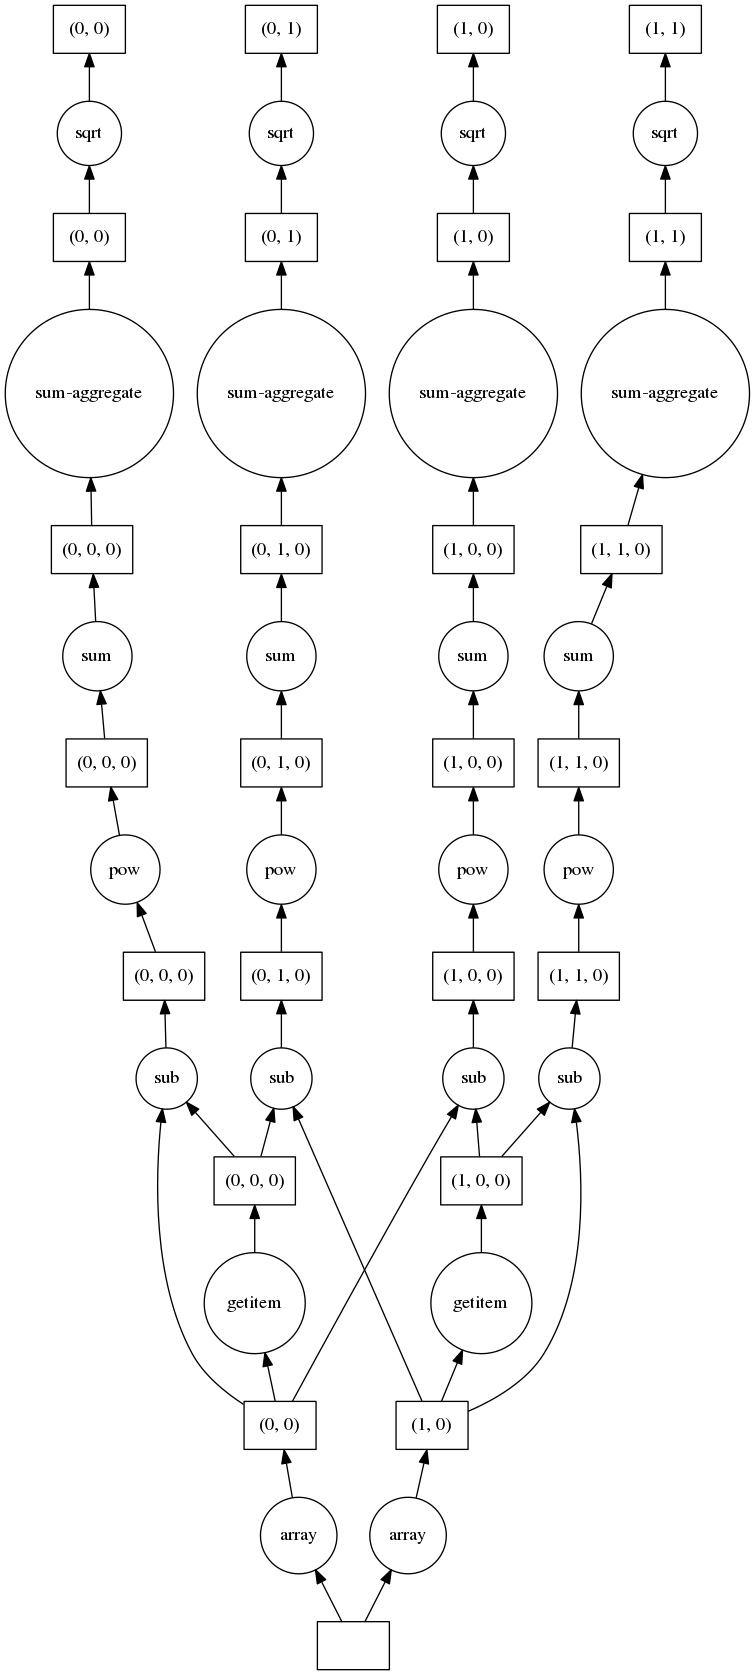

In [63]:
D_3.visualize()

In [64]:
assert_we_are_happy(D_3.compute())

Yes


In [65]:
%timeit D_3.compute()

17.3 ms ± 743 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Choose a different scheduler / executor

In [66]:
# globally
dask.config.set(scheduler='threads')

In [67]:
%timeit D_3.compute()

17.5 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
# or per call
%timeit D_3.compute(scheduler='synchronous')

27.6 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Using `dask.distributed`

* Set up a pool (local or truly distributed on a cluster) of workers.
* Can be used for `compute`

In [69]:
# note: this also sets up the default scheduler
client = dask.distributed.Client(processes=True)

In [70]:
assert_we_are_happy(D_3.compute(scheduler=client))

Yes


In [71]:
%timeit D_3.compute(scheduler=client)

117 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Summary

Use Python for numerics


* Powerful tools exist for optimizing numerical calculations in Python.
* Efficient optimization can tak as little as a single `@jit` decorator.
* Be careful with memory use (of Numpy broadcasting).
* Remember `concurrent.futures` for parallelization.

These slides are available at https://github.com/coobas/pydata-prague-optimization-2019